<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#stats stuff
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split

## Load Data

In [2]:
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.columns = df.columns.map(lambda x: x.replace(' ','_'))

In [4]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


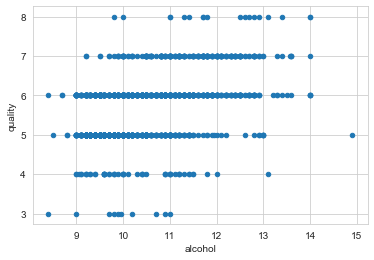

In [179]:
df.plot(x='alcohol',y='quality',kind='scatter');

## Check for Multicollinearity

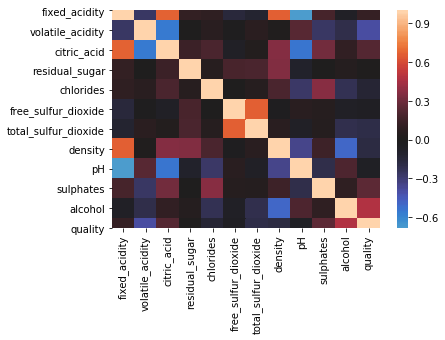

In [5]:
sns.heatmap(df.corr(),center=0);

In [6]:
(abs(df.corr()) > 0.75).sum()

fixed_acidity           1
volatile_acidity        1
citric_acid             1
residual_sugar          1
chlorides               1
free_sulfur_dioxide     1
total_sulfur_dioxide    1
density                 1
pH                      1
sulphates               1
alcohol                 1
quality                 1
dtype: int64

These two above cells confirm no multicollinearity to worry about.

## Visualize Non-Transformed Data

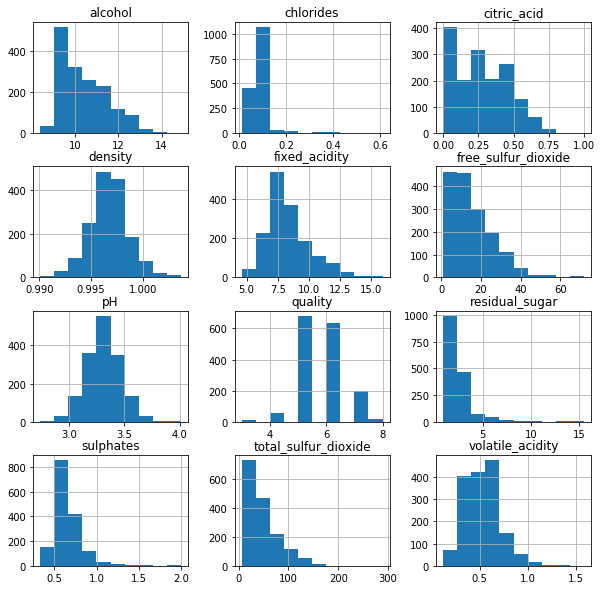

In [7]:
df.hist(figsize  = [10, 10]); 

The above visuals show that density and pH are already normally-distributed. Others will need to be log transformed. Several columns have values between 0 and 1, and thus will need to be transformed according to log(x+1).

The quality column has mostly values at 5 or 6, which probably won't tell us much about any of the other variables. We therefore will omit this from our exploration.

## Log Transform

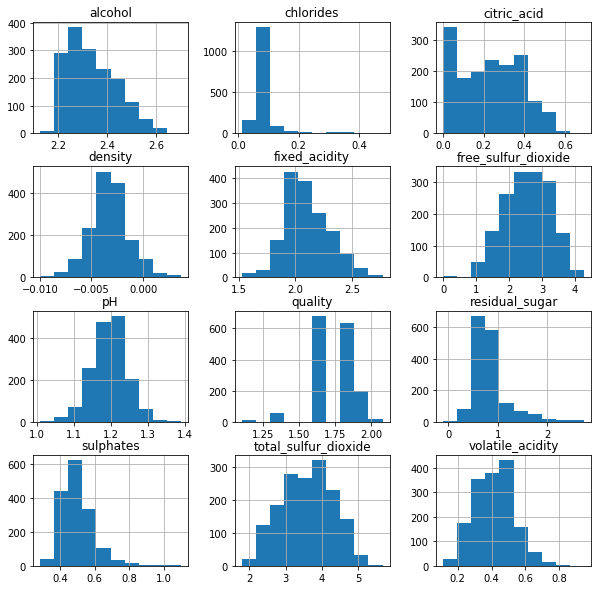

In [20]:
# Create log-transformed DF
df_log = pd.DataFrame([])

# Keep track of which categories to apply which transformations to (The slicing gets rid of the quality column)
cats = df.columns
non_log_cats = ['pH','density']
offset_log_cats = ['citric_acid','free_sulphur_dioxide','chlorides','volatile_acidity', 'sulphates']

# Iterate
for cat in cats:
    
    # Don't transform already normally-distributed data
    if cat in non_log_cats:
        df_log[cat] = df[cat]
        
    # Add 1 and THEN log transform columns containing values between [0,1)
    if cat in offset_log_cats:
        df_log[cat] = np.log(df[cat] + 1)
    
    # Log transform everything else
    else:
        df_log[cat] = np.log(df[cat])


df_log.hist(figsize  = [10, 10]);

## Feature Scaling

We are going to min-max scale to get our data between 0 and 1 for multiple linear regression.

In [38]:
y = df[["alcohol"]]
X = df_log #.drop(labels='alcohol',axis=1)

scale = MinMaxScaler()
transformed = scale.fit_transform(X)
X = pd.DataFrame(transformed, columns = X.columns)

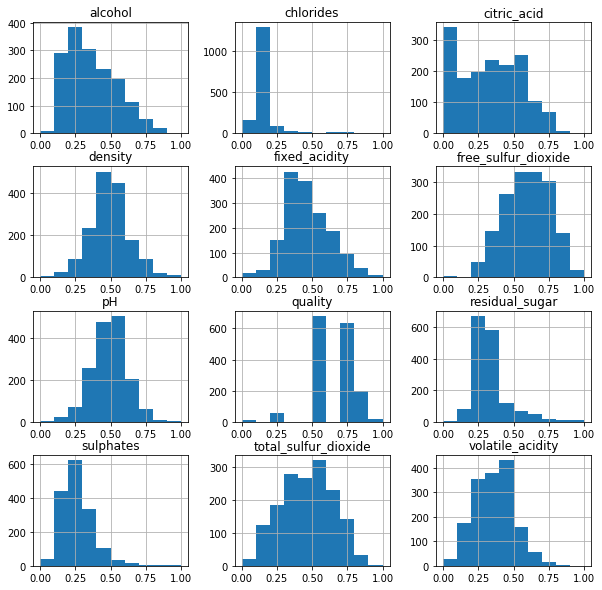

In [39]:
X.hist(figsize  = [10, 10]);

## Feature Engineering

In [65]:
def check_interaction(df_high,df_low,iv,dv,grouped_var):
    """
    Plots a scatter plot of the dependent variable [dv] as a function of the independent variable [iv]
    when iv is split into two groups, as denoted by df_high and df_low. These two dataframes must contain mutually
    exclusive data.
    
    Param df_high: [pandas DataFrame] First split (high values)
    Param df_low: [pandas DataFrame] First split (low values)
    Param iv: [str] the name of the independent variable exactly as it appears in the dataframes.
    Param dv: [str] the name of the dependent variable exactly as it appears in the dataframes.
    Param grouped_var: [str] the name of the variable that was used to split the iv into two dataframes. Must
                       be written exactly as it appears in the dataframe.
    """

    plt.figure(figsize=(12,7));

    regression_1 = LinearRegression()
    regression_2 = LinearRegression()

    high_data = df_high[iv].values.reshape(-1, 1)
    low_data = df_low[iv].values.reshape(-1, 1)

    regression_1.fit(high_data, df_high[dv])
    regression_2.fit(low_data, df_low[dv])

    # Make predictions using the testing set
    pred_1 = regression_1.predict(high_data)
    pred_2 = regression_2.predict(low_data)

    # The coefficients
    print('regression coeff 1 is ', regression_1.coef_)
    print('regression coeff 2 is ', regression_2.coef_)
    
    # Plot outputs
    plt.figure(figsize=(10,6));

    plt.scatter(high_data, df_high[dv],  color='blue', alpha = 0.3, label = f'high {grouped_var}');
    plt.scatter(low_data, df_low[dv],  color='red', alpha = 0.3, label = f'low {grouped_var}');

    plt.plot(high_data, pred_1,  color='blue', linewidth=2);
    plt.plot(low_data, pred_2,  color='red', linewidth=2);

    plt.ylabel(dv)
    plt.xlabel(iv)
    plt.title(f'Interaction between {iv} and {grouped_var}')
    plt.legend();

regression coeff 1 is  [0.49393038]
regression coeff 2 is  [0.55048891]


<Figure size 864x504 with 0 Axes>

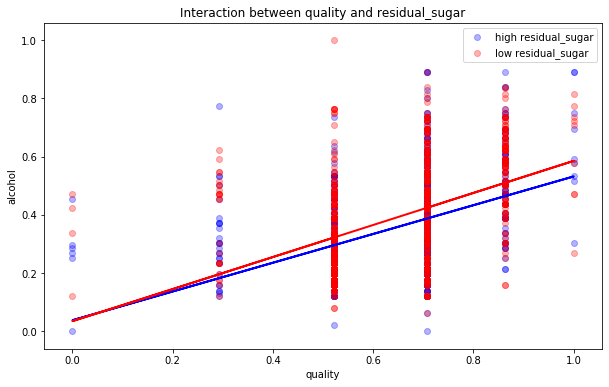

In [66]:
high_sug = X[X.residual_sugar < 0.3]
low_sug = X[X.residual_sugar >= 0.3]
check_interaction(high_sug,low_sug,'quality','alcohol','residual_sugar');

Intersecting lines above suggest there is some light interaction between residual sugar and quality. We should therefore engineer a column in our dataset called quality_res_sugar.

regression coeff 1 is  [-1.00771164]
regression coeff 2 is  [-0.61149341]


<Figure size 864x504 with 0 Axes>

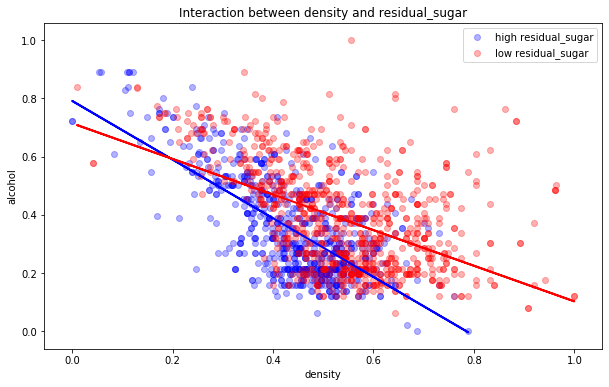

In [67]:
check_interaction(high_sug,low_sug,'density','alcohol','residual_sugar');

Intersecting lines above suggest there is significant interaction between residual sugar and density. We should therefore engineer a column in our dataset called density_res_sugar.

regression coeff 1 is  [0.20011766]
regression coeff 2 is  [0.18109263]


<Figure size 864x504 with 0 Axes>

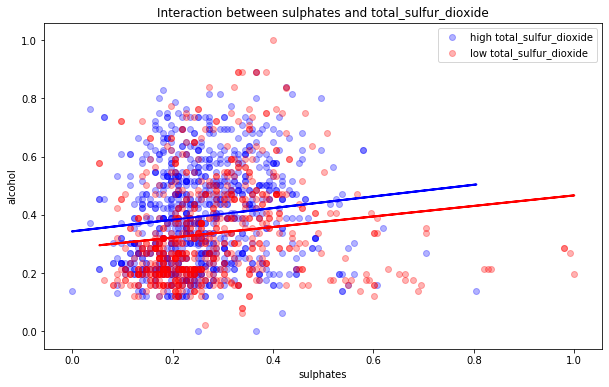

In [68]:
high_sulfur = X[X.total_sulfur_dioxide < 0.5]
low_sulfur = X[X.total_sulfur_dioxide >= 0.5]
check_interaction(high_sulfur,low_sulfur,'sulphates','alcohol','total_sulfur_dioxide');

Parallel lines, therefore no interaction.

regression coeff 1 is  [0.43315352]
regression coeff 2 is  [0.63578078]


<Figure size 864x504 with 0 Axes>

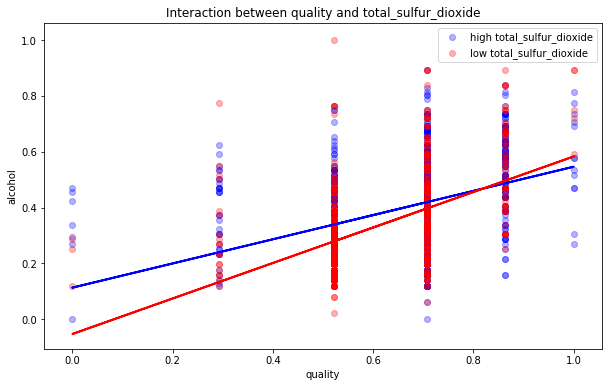

In [69]:
check_interaction(high_sulfur,low_sulfur,'quality','alcohol','total_sulfur_dioxide');

Intersecting lines above suggest there is some light interaction between total sulfur dioxide and quality. We should therefore engineer a column in our dataset called quality_tsd.

# Statistical Modeling - Initial Model

In [40]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [41]:
data_ols = X
data_ols.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,0.383325,0.500083,0.000000,0.262530,0.131896,0.560693,0.447677,0.569223,0.650306,0.196091,0.196252,0.520810
1,0.425771,0.620692,0.000000,0.372733,0.175429,0.752660,0.622746,0.495834,0.407509,0.287196,0.268963,0.520810
2,0.425771,0.541649,0.056584,0.329657,0.163644,0.633215,0.567074,0.510518,0.456287,0.265045,0.268963,0.520810
3,0.717475,0.160021,0.641546,0.262530,0.129896,0.662482,0.594267,0.583892,0.374479,0.211752,0.268963,0.706695
4,0.383325,0.500083,0.000000,0.262530,0.131896,0.560693,0.447677,0.569223,0.650306,0.196091,0.196252,0.520810


In [42]:
# Create the formula of form "outcome ~ predictor_1+predictor_2+...+predictor_n"
data_ols = X
outcome = 'alcohol'
predictors = data_ols.drop('alcohol', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

model = ols(formula= formula, data=data_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     338.6
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:34:22   Log-Likelihood:                 1506.8
No. Observations:                1599   AIC:                            -2990.
Df Residuals:                    1587   BIC:                            -2925.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1416      0.031     -4.637      0.000      -0.202      -0.082
fixed_acidity            0.8501      0.036     23.661      0.000       0.780       0.921
volatile_acidity         0.1235      0.024      5.165      0.000       0.077       0.170
citric_acid              0.1146      0.019      6.132      0.000       0.078       0.151
residual_sugar           0.5704      0.022     26.020      0.000       0.527       0.613
chlorides               -0.1053      0.034     -3.111      0.002      -0.172      -0.039
free_sulfur_dioxide     -0.0056      0.025     -0.223      0.823      -0.055       0.044
total_sulfur_dioxide    -0.0781      0.023     -3.360      0.001      -0.124      -0.033
density                 -1.3205      0.031    -42.199      0.000      -1.382      -1.259
pH                       0.7358      0.031     23.488      0.000       0.674       0.797
sulphates                0.2731      0.024     11.192      0.000       0.225       0.321
quality                  0.1773      0.019      9.251      0.000       0.140       0.215
==============================================================================
Omnibus:                      141.656   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.028
Skew:                           0.634   Prob(JB):                     9.21e-52
Kurtosis:                       4.386   Cond. No.                         41.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that $p_\text{free sulfur dioxide} > \alpha$ so we will eliminate this predictor from the model. Also, free sulfur dioxide is accounted for in total sulfur dioxide, so we don't really lose much by eliminating this predictor.

In [43]:
X.drop(['free_sulfur_dioxide'],axis=1,inplace=True)

## Take 2

In [44]:
# Create the formula of form "outcome ~ predictor_1+predictor_2+...+predictor_n"
data_ols = X
outcome = 'alcohol'
predictors = data_ols.drop('alcohol', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

model = ols(formula= formula, data=data_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     372.6
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:34:25   Log-Likelihood:                 1506.8
No. Observations:                1599   AIC:                            -2992.
Df Residuals:                    1588   BIC:                            -2932.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1427      0.030     -4.729      0.000      -0.202      -0.084
fixed_acidity            0.8491      0.036     23.859      0.000       0.779       0.919
volatile_acidity         0.1241      0.024      5.232      0.000       0.078       0.171
citric_acid              0.1153      0.018      6.258      0.000       0.079       0.151
residual_sugar           0.5701      0.022     26.068      0.000       0.527       0.613
chlorides               -0.1056      0.034     -3.124      0.002      -0.172      -0.039
total_sulfur_dioxide    -0.0822      0.014     -5.815      0.000      -0.110      -0.054
density                 -1.3194      0.031    -42.708      0.000      -1.380      -1.259
pH                       0.7348      0.031     23.715      0.000       0.674       0.796
sulphates                0.2730      0.024     11.194      0.000       0.225       0.321
quality                  0.1771      0.019      9.257      0.000       0.140       0.215
==============================================================================
Omnibus:                      142.093   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.039
Skew:                           0.635   Prob(JB):                     5.56e-52
Kurtosis:                       4.390   Cond. No.                         38.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Intercept p value is still $> \alpha$ but we will proceed for now.

In [45]:
def compare_fits(X,y,test_size=0.2, alpha=0.5):
    """
    Print out fit comparisons between linear, ridge, and lasso regressions.
    
    Param X: predictors
    Param y: outcome
    Param test_size: percentage of data set to be used as the test sample
    Param alpha: hyperparameter for ridge and lasso. Must be [0,1].
    """
    # Perform test train split
    X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

    # Build a Ridge, Lasso and regular linear regression model. 
    # Note how in scikit learn, the regularization parameter is denoted by alpha (and not lambda)
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)

    lin = LinearRegression()
    lin.fit(X_train, y_train)
    
#     print("Unpenalized Linear Regression Coefficients are:{}".format(dict(zip(X.columns,lin.coef_[0]))))
#     print("\nUnpenalized Linear Regression Intercept:{}".format(lin.intercept_))
#     print('\n')
#     print("\nLasso Regression Coefficients are:{}".format(dict(zip(X.columns,lasso.coef_))))
#     print("\nLasso Linear Regression Intercept:{}".format(lasso.intercept_))
#     print('\n')
#     print("\nRidge Regression Coefficients are:{}".format(dict(zip(X.columns,ridge.coef_[0]))))
#     print("\nRidge Linear Regression Intercept:{}".format(ridge.intercept_))
#     print('\n')
    # create predictions
    y_h_ridge_train = ridge.predict(X_train)
    y_h_ridge_test = ridge.predict(X_test)

    y_h_lasso_train = np.reshape(lasso.predict(X_train),(1279,1))
    y_h_lasso_test = np.reshape(lasso.predict(X_test),(320,1))

    y_h_lin_train = lin.predict(X_train)
    y_h_lin_test = lin.predict(X_test)
    
    # examine the residual sum of sq
#     print('---------------------------------------')
#     print('Train Error Ridge Model', np.sum((y_train - y_h_ridge_train)**2))
#     print('Test Error Ridge Model', np.sum((y_test - y_h_ridge_test)**2))
#     print('\n')

#     print('Train Error Lasso Model', np.sum((y_train - y_h_lasso_train)**2))
#     print('Test Error Lasso Model', np.sum((y_test - y_h_lasso_test)**2))
#     print('\n')

#     print('Train Error Unpenalized Linear Model', np.sum((y_train - lin.predict(X_train))**2))
#     print('Test Error Unpenalized Linear Model', np.sum((y_test - lin.predict(X_test))**2))
    
    train_error_ridge = np.sum((y_train - y_h_ridge_train)**2)
    test_error_ridge = np.sum((y_test - y_h_ridge_test)**2)
    
    train_error_linear = np.sum((y_train - lin.predict(X_train))**2)
    test_error_linear = np.sum((y_test - lin.predict(X_test))**2)
    
    return [train_error_ridge[0], test_error_ridge[0], train_error_linear[0], test_error_linear[0]]

In [46]:
data = [[round(x,1)] + compare_fits(X,y,test_size=0.2, alpha=x) for x in np.arange(0.1, 1, 0.1)]

fits_df = pd.DataFrame(data,columns = ['alpha','train_error_ridge','test_error_ridge','train_error_linear','test_error_linear'])

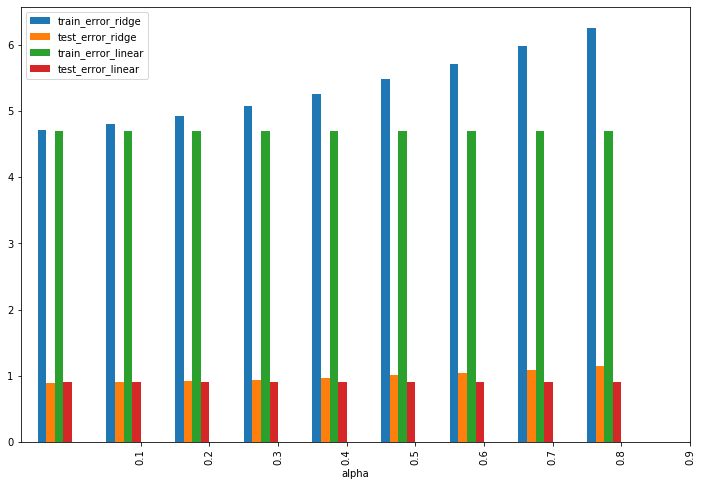

In [47]:
fits_df.plot(x='alpha',kind='bar',position=3,figsize=(12,8))

The nonpenalized model is superior to the penalized linear models.

## Model Using Engineered Features

### Add to DF

In [ ]:
# Create new df with engineered features

X_eng = X.copy(deep=True)

# pH as grouped variable
X_eng['ph_fixed_a'] = X.fixed_acidity * X.pH
X_eng['ph_volatile_a'] = X.volatile_acidity * X.pH
X_eng['ph_citric_a'] = X.citric_acid * X.pH
X_eng['ph_chlorides'] = X.chlorides * X.pH
X_eng['ph_quality'] = X.quality * X.pH

# Residual Sugar as grouped var
X_eng['res_sug_quality'] = X.quality * X.residual_sugar
X_eng['res_sug_density'] = X.density * X.residual_sugar

# Total sulfur dioxide as grouped var
X_eng['tsd_quality'] = X.quality * X.total_sulfur_dioxide

### Create Model

In [73]:
# Create the formula of form "outcome ~ predictor_1+predictor_2+...+predictor_n"
data_ols = X_eng
outcome = 'alcohol'
predictors = data_ols.drop('alcohol', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

model = ols(formula= formula, data=data_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     230.2
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:46:18   Log-Likelihood:                 1570.2
No. Observations:                1599   AIC:                            -3102.
Df Residuals:                    1580   BIC:                            -3000.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1862      0.084     -2.214      0.027      -0.351      -0.021
fixed_acidity            1.2097      0.075     16.131      0.000       1.063       1.357
volatile_acidity         0.2420      0.086      2.806      0.005       0.073       0.411
citric_acid              0.2084      0.073      2.836      0.005       0.064       0.353
residual_sugar           0.3736      0.094      3.964      0.000       0.189       0.558
chlorides               -0.1759      0.090     -1.963      0.050      -0.352      -0.000
total_sulfur_dioxide    -0.2342      0.054     -4.365      0.000      -0.339      -0.129
density                 -1.4525      0.047    -30.823      0.000      -1.545      -1.360
pH                       1.1221      0.137      8.181      0.000       0.853       1.391
sulphates                0.2506      0.024     10.307      0.000       0.203       0.298
quality                  0.0027      0.091      0.030      0.976      -0.176       0.181
ph_fixed_a              -0.7766      0.134     -5.790      0.000      -1.040      -0.514
ph_volatile_a           -0.2844      0.166     -1.715      0.087      -0.610       0.041
ph_citric_a             -0.2019      0.140     -1.441      0.150      -0.477       0.073
ph_chlorides             0.2293      0.220      1.044      0.297      -0.201       0.660
ph_quality               0.1169      0.135      0.868      0.385      -0.147       0.381
res_sug_quality         -0.0101      0.114     -0.089      0.929      -0.233       0.213
res_sug_density          0.3727      0.098      3.805      0.000       0.181       0.565
tsd_quality              0.2569      0.084      3.049      0.002       0.092       0.422
==============================================================================
Omnibus:                       92.471   Durbin-Watson:                   1.617
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.967
Skew:                           0.419   Prob(JB):                     1.24e-37
Kurtosis:                       4.360   Cond. No.                         206.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Remove predictors with $p>\alpha$ and model again

In [91]:
# Drop useless columns
X_eng_2 = X_eng.drop(labels=['res_sug_quality','ph_quality','quality','tsd_quality','ph_volatile_a','ph_chlorides','ph_citric_a'],axis=1)

In [92]:
# Create the formula of form "outcome ~ predictor_1+predictor_2+...+predictor_n"
data_ols = X_eng_2
outcome = 'alcohol'
predictors = data_ols.drop('alcohol', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum

model = ols(formula= formula, data=data_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     348.0
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:55:57   Log-Likelihood:                 1522.3
No. Observations:                1599   AIC:                            -3021.
Df Residuals:                    1587   BIC:                            -2956.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1360      0.040     -3.419      0.001      -0.214      -0.058
fixed_acidity            1.3332      0.057     23.460      0.000       1.222       1.445
volatile_acidity         0.0553      0.023      2.389      0.017       0.010       0.101
citric_acid              0.0968      0.018      5.267      0.000       0.061       0.133
residual_sugar           0.3799      0.059      6.389      0.000       0.263       0.497
chlorides               -0.1146      0.033     -3.429      0.001      -0.180      -0.049
total_sulfur_dioxide    -0.0844      0.014     -6.031      0.000      -0.112      -0.057
density                 -1.5445      0.047    -33.047      0.000      -1.636      -1.453
pH                       1.1425      0.051     22.421      0.000       1.043       1.242
sulphates                0.3095      0.023     13.271      0.000       0.264       0.355
ph_fixed_a              -0.8986      0.097     -9.231      0.000      -1.090      -0.708
res_sug_density          0.4135      0.100      4.132      0.000       0.217       0.610
==============================================================================
Omnibus:                       93.998   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.365
Skew:                           0.396   Prob(JB):                     7.58e-42
Kurtosis:                       4.488   Cond. No.                         88.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model seems acceptable.

### Test LR Assumptions

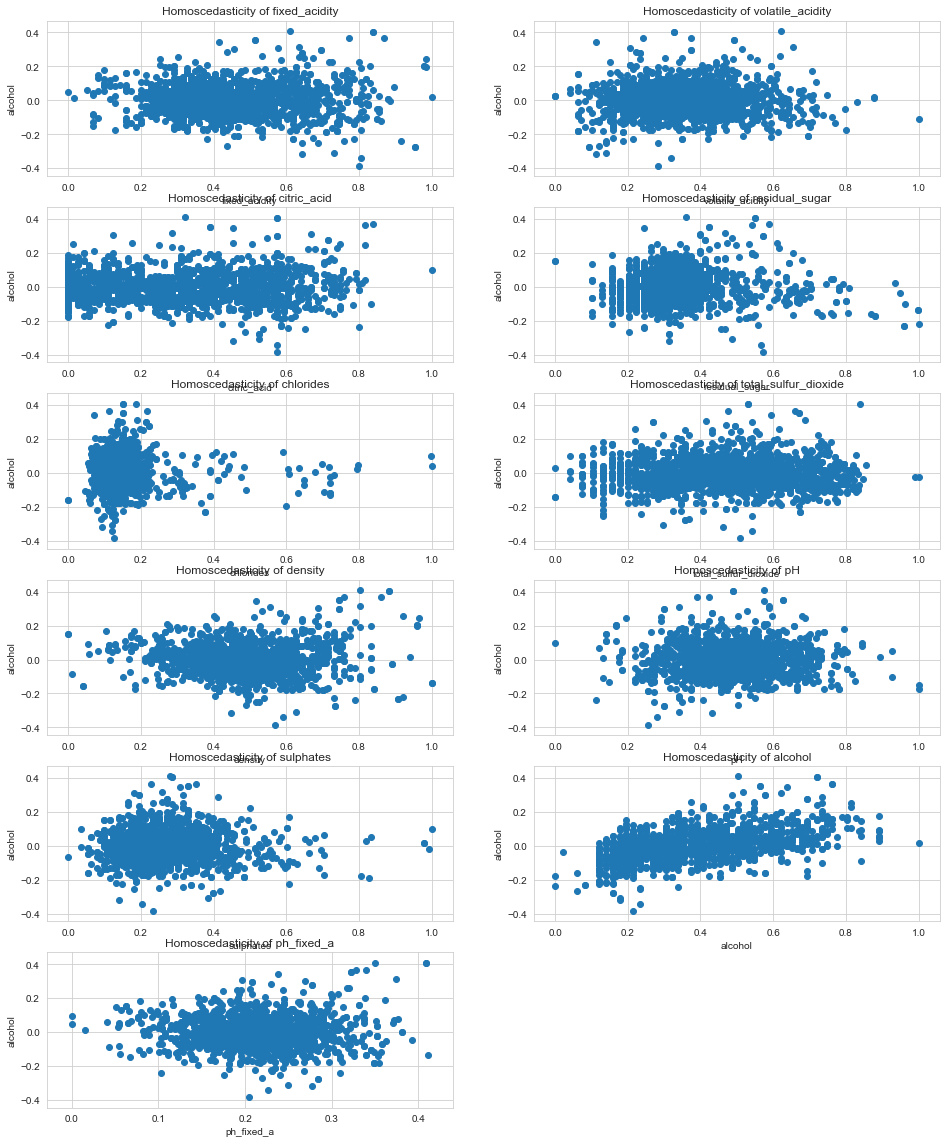

In [170]:
sns.set_style('whitegrid')

# checking for our model - Homoscedasticity
pred_val = model.fittedvalues.copy()
true_val = X_eng_2['alcohol'].values.copy()
residual = true_val - pred_val

# Instantiate figure
fig = plt.figure(figsize=(16,20))


predictors = X_eng_2.columns
for n in range(1,12):
    ax = plt.subplot(6,2,n)
    ax.scatter(X_eng_2[predictors[n-1]],residual)
    ax.set_xlabel(predictors[n-1]), ax.set_ylabel('alcohol')
    ax.set_title(f'Homoscedasticity of {predictors[n-1]}')
    

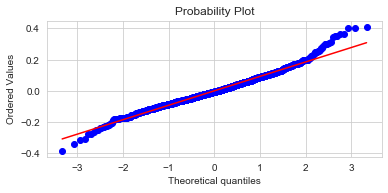

In [172]:
# checking for normality - QQ plot 
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
sp.stats.probplot(residual, plot=ax, fit=True);

The error in our model is more extreme at the tails, therefore our model is only valid for the large area under the curve.